# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Fri Mar 18 11:34:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   53C    P5    22W / 240W |    396MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
#from rdkit import Chem
#from rdkit.Chem import AllChem

In [4]:
dataset = 'CHEMBL205'

In [5]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/dataset/f'{dataset}_train_valid.csv')

In [6]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/.ipynb_checkpoints'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240')]

In [7]:
DATA = path/'mol_images'

In [8]:
IMAGES = DATA/dataset

# Create train validation split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df.is_valid.value_counts()

False    14352
True      3589
Name: is_valid, dtype: int64

In [11]:
len(df[df.is_valid == True]) / len(df[df.is_valid == False])

0.2500696767001115

# Create dataloader

In [12]:
from fastai.vision.all import *

In [13]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL188002,S(=O)(=O)(N)c1cc(N/C(/S)=N\c2cc(C(=O)[O-])c(cc2)C=2c3c(OC4=CC(=O)C=CC=24)cc(O)cc3)ccc1,1,False,CHEMBL188002.png
1,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
2,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
3,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
4,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png


In [14]:
images = df['CID'] + ".png"
images.head()

0     CHEMBL188002.png
1     CHEMBL364127.png
2    CHEMBL1683469.png
3      CHEMBL52564.png
4      CHEMBL21427.png
Name: CID, dtype: object

In [15]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [16]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=None,
    )

Oversmaple instead of using class weights to test custom loss function

In [17]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df


In [18]:
def get_df(dataset, random_state=42, test_size=0.25, oversample=True):
    df = pd.read_csv(path/dataset/f'{dataset}_cl.csv')
    df = val_cols_and_oversample(df, test_size=test_size, random_state=random_state, oversample=oversample)
    df['Image'] = df['CID'] + '.png'
    return df

In [19]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.25):
    df = pd.read_csv(path/dataset/f'{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [20]:
df = get_df(dataset)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL364127,Clc1ccc(cc1)C(=O)NC1Cc2cc(S(=O)(=O)N)ccc2C1,1,False,CHEMBL364127.png
1,CHEMBL1683469,S(=O)(=O)(N)c1ccc(cc1)CNS(=O)(=O)CC12CCC(CC1=O)C2(C)C,1,False,CHEMBL1683469.png
2,CHEMBL52564,Oc1ccccc1\C=C\C(=O)[O-],1,False,CHEMBL52564.png
3,CHEMBL21427,OB(O)c1ccc(OC)cc1,1,False,CHEMBL21427.png
4,CHEMBL1414,O(C)c1cc(cc(OC)c1O)C(=O)[O-],1,False,CHEMBL1414.png


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28948 entries, 0 to 28947
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       28948 non-null  object
 1   SMILES    28948 non-null  object
 2   Activity  28948 non-null  int64 
 3   is_valid  28948 non-null  object
 4   Image     28948 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.1+ MB


In [22]:
IMAGES = DATA/f'{dataset}_cl'
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205_cl')

In [23]:
def get_dls(dataset, bs=64, clustering=False, random_state=42):
    IMAGES = DATA/f'{dataset}_cl'
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else: 
        df = get_df(dataset, oversample=True)
    db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=ColSplitter('is_valid'),
        item_tfms=None, 
        batch_tfms=None,
        )
    dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42, num_workers=0)
    return dls, df

In [24]:
dls, df = get_dls(dataset, clustering=False)

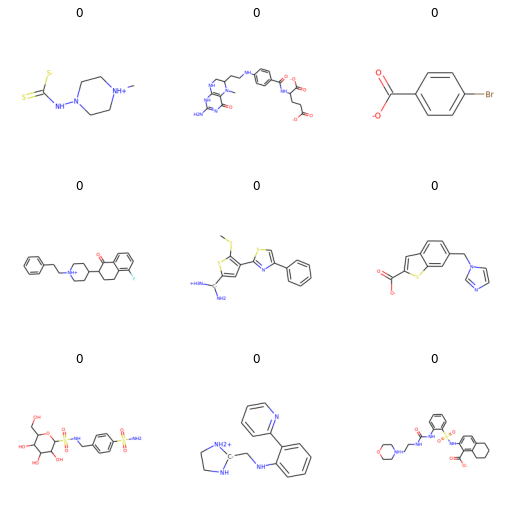

In [25]:
dls.show_batch()

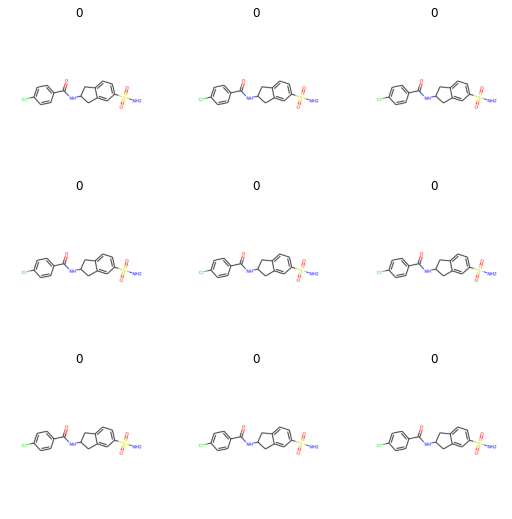

In [26]:
dls.show_batch(unique=True)

# Create class weights

In [27]:
TARGET = 'Activity'

In [28]:
train_df = df[df.is_valid == False]

In [29]:
class_count_df = train_df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,12232,12232,12232,12232
1,12230,12230,12230,12230


In [30]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [31]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.9999182472204055, 1.0000817661488144)

In [32]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [33]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [34]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [35]:
loss_func=get_loss_func(df)

# Train CNN model

In [39]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
from utils.losses import * 

In [40]:
from fastai.callback.hook import *

In [41]:
def train_model(dls, arch=resnet18, loss_func=None, metric = None, epochs=16, wd=None, lr=None):
    
    
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    if metric == None: 
        learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()]).to_fp16()
    else: 
        learn = cnn_learner(dls, arch=arch, pretrained=True, 
                                wd=wd,
                                loss_func=loss_func,
                                metrics=[accuracy, 
                                F1Score(), 
                                Precision(), 
                                Recall(), 
                                RocAucBinary(), 
                                MatthewsCorrCoef(), 
                                metric]).to_fp16()
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [ ]:
# Train model on resnet18
learn = train_model(dls,loss_func=None, epochs=5, lr=3e-3, wd=0.002)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

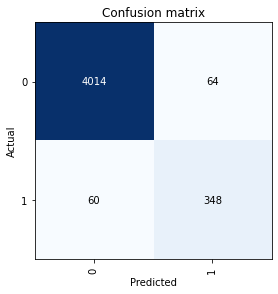

In [41]:
interp.plot_confusion_matrix()

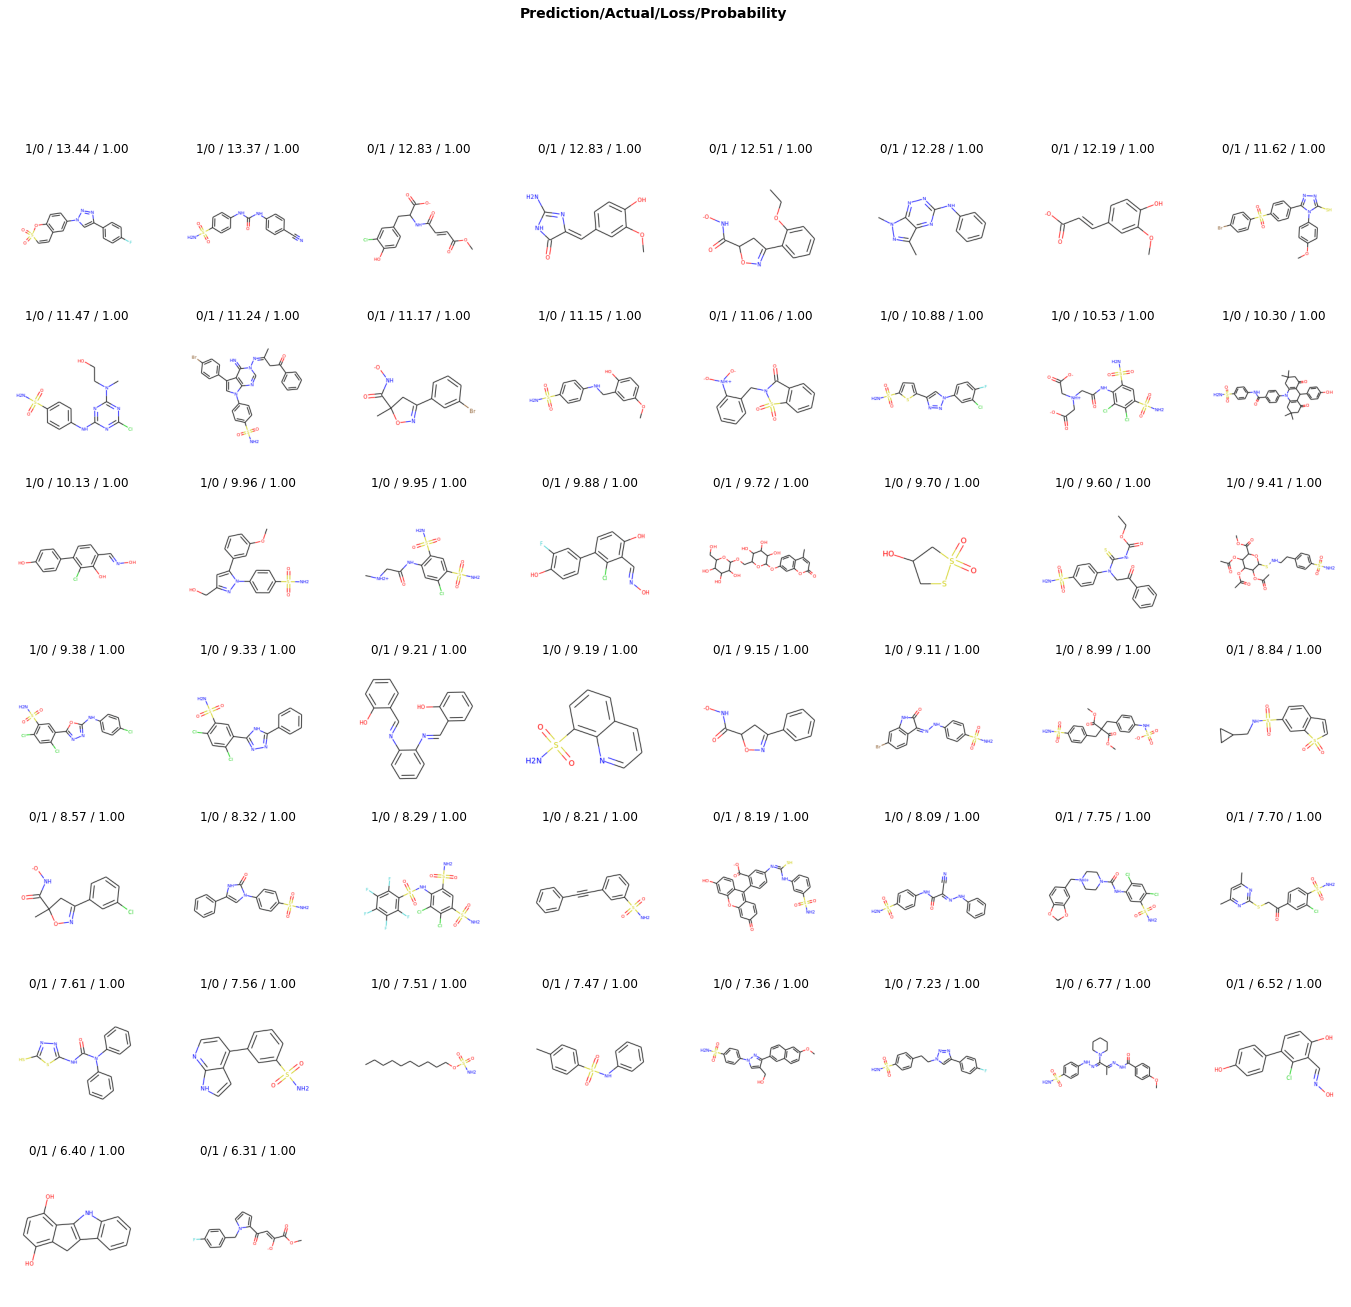

In [42]:
interp.plot_top_losses(k=50)

# Test for metric with cost

In [43]:
cost = [100, 1]

In [44]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [45]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0 = w_0 * cost[0]
w_1 = w_1 * cost[1]
w_0, w_1

(99.99182472204055, 1.0000817661488144)

In [46]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [47]:
decision_loss = nn.CrossEntropyLoss(weight=class_weights)
type(decision_loss)

torch.nn.modules.loss.CrossEntropyLoss

In [48]:
type(F1Score())

fastai.metrics.AccumMetric

In [49]:
# Train model on resnet18
learn = train_model(dls,loss_func=loss_func, metric=decision_loss, epochs=1, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=1
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.229574,0.321096,0.897013,0.616279,0.466080,0.909314,0.961278,0.605943,0.322096,01:24


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.070795,0.122036,0.967900,0.837472,0.776151,0.909314,0.982980,0.822950,0.122370,01:40


In [50]:
interp = ClassificationInterpretation.from_learner(learn)

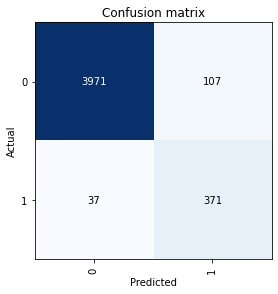

In [51]:
interp.plot_confusion_matrix()

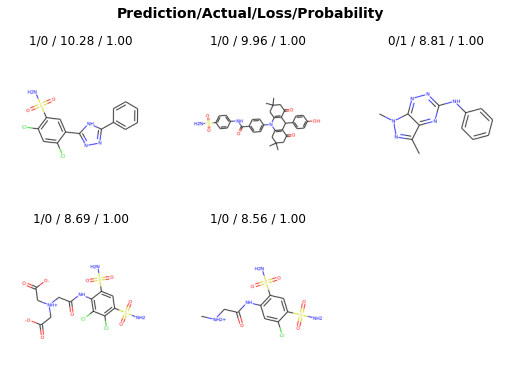

In [52]:
interp.plot_top_losses(k=5)

In [61]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

# Cost-sensitive loss function



There's a simple idea behind a Cost-Sensitive Loss: we impose a different penalty to different kind of errors. For illustration purposes, imagine you have a three-class classification problem and you wish to impose a greater penalty to errors in misclassifying class 2 as class 0, but you don't care about the other errors.*

In [53]:
import torch
from torch import nn
import torch.nn.functional as F

In [54]:
n_classes = 2

In [55]:
cs_loss = CostSensitiveLoss(n_classes, normalization='sigmoid')

In [56]:
print(cs_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [57]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_loss.M = M


In [58]:
print(cs_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


In [59]:
# Train model on resnet18
learn = train_model(dls,loss_func=cs_loss, metric=cs_loss, epochs=1, lr=3e-3, wd=0.002)

Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=1
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.008239,0.006241,0.929336,0.636884,0.597849,0.681373,0.940932,0.599497,0.006241,01:25


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,None,time
0,0.002227,0.001439,0.933125,0.592391,0.664634,0.534314,0.929524,0.560368,0.001439,01:41


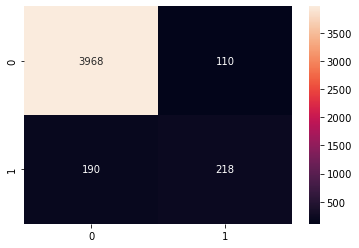

<AxesSubplot:>

In [63]:
show_confusion_matrix(learn, dls.valid)

**Results**: Just training for 1 epoch, number of False Positives went down, number of False Negatives went up (as expected), but number of True positives also went down which is bad. 

# Regularized cost-sensitive loss function

In our experiments (and elsewhere) we found out that simply using a CS loss leads to lots of trouble in terms of CNNs staying at local minima where they will predict a trivial configuration (all the time the same category), which seems to be very satisfying for this kind of losses. For this reason, we recommend using this as a regularizer for other standard classification losses (just a weighted sum of both, with a weighing parameter `lambd`). \
In our implementation we provide a wrapper for doing this, where you specify a `base_loss` and the regularization parameter `lambd`:


In [64]:
n_classes = 2 
base_loss = 'ce'
lambd = 10
cs_regularized_loss = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)

In [65]:
print(cs_regularized_loss.M)

tensor([[0., 1.],
        [1., 0.]])


In [66]:
M = np.array([[0,10],
              [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)
cs_regularized_loss.M = M

In [67]:
print(cs_regularized_loss.M)

tensor([[0.0000, 1.0000],
        [0.1000, 0.0000]])


In [ ]:
# Train model on resnet18
learn = train_model(dls,loss_func=cs_regularized_loss, metric=cs_regularized_criterion, epochs=1, lr=3e-3, wd=0.002)

In [ ]:
preds, y = learn.get_preds(dl=dls.valid)

In [ ]:
preds

In [50]:
def show_confusion_matrix(learn, dl):
    preds, y = learn.get_preds(dl=dl)
    pred = preds.argmax(axis=1)
    cm = confusion_matrix(y, pred)
    f = sns.heatmap(cm, annot=True, fmt='d')
    plt.show()
    return f

In [ ]:
show_confusion_matrix(learn, dls.valid)

**Results**:  False positives went drastically down, and true positives up compared to just using cost-sensitive loss, precision is higher then using regular cross entropy loss so could be a bit random. 

### Train for 10 epochs: 

In [ ]:
learn = train_model(dls,loss_func=cs_regularized_loss, metric=cs_regularized_criterion, epochs=10, lr=3e-3, wd=0.002)

In [ ]:
show_confusion_matrix (learn, dls)

# Compare regularized cost-sensitive loss functions

In [44]:
from utils.losses import *

Compare: Cross entropy (CE), CE with Label Smoothing (LS), CE with Gaussian LS

In [74]:
losses = ['ce']

In [76]:
M = np.array([[0,20],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

In [49]:
def train_model_with_loss(base_loss='ce', n_classes = 2, lambd = 10):
    loss = CostSensitiveRegularizedLoss(n_classes=n_classes, base_loss=base_loss, lambd=lambd)
    loss.M = M
    learn = train_model(dls,loss_func=loss, epochs=5, lr=3e-3, wd=0.002)
    cm = show_confusion_matrix(learn, dls.valid)
    return learn, cm

In [112]:
recorders = []

In [113]:
logs = []

Training model with base loss function ce and lambd: 10
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.724984,0.671954,0.946723,0.741622,0.663443,0.840686,0.965766,0.718589,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.296038,0.346091,0.964111,0.800000,0.811083,0.789216,0.974846,0.780378,01:28
1,0.147529,0.333376,0.970352,0.838002,0.832930,0.843137,0.980438,0.821705,01:28
2,0.047226,0.279823,0.971690,0.838628,0.870712,0.808824,0.983105,0.823807,01:28


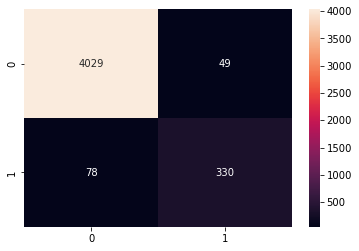

In [116]:
lambd = 10
for l in losses:
    if l == 'gls':
        lambd = 2
    print(f'Training model with base loss function {l} and lambd: {lambd}')
    base_loss = l
    model, _ = train_model_with_loss(base_loss=base_loss, lambd=lambd)
    recorders.append(model)

In [117]:
log = recorders[0].recorder.after_epoch()
log

[0, 0.27982261776924133, 0.9716897010803223, 0.8386277001270648, 0.8707124010554089, 0.8088235294117647, 0.9831051842021753, 0.8238067231495001, '00:07', '00:43']


In [118]:
interp = ClassificationInterpretation.from_learner(recorders[0])

In [119]:
interp.plot_top_losses(k=5)

TypeError: no implementation found for 'torch.Tensor.__getitem__' on types that implement __torch_function__: [TensorImage, TensorCategory]

# Test different lambdas

Lamdas is used to choose how much you will weight the cost-sensitive loss functions vs cross-entropy

In [61]:
lambdas = [0, 0.1, 1, 10]
lambdas

[0, 0.1, 1, 10]

In [67]:
learners = []

Training model with base loss function ce and lambda: 0
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.248337,0.248303,0.915961,0.666076,0.521498,0.921569,0.968122,0.655258,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.102976,0.173708,0.954079,0.785417,0.682971,0.924020,0.978593,0.771250,01:28
1,0.047397,0.124903,0.968346,0.832547,0.802273,0.865196,0.979754,0.815804,01:27
2,0.006592,0.128534,0.972358,0.850602,0.836493,0.865196,0.980407,0.835522,01:27


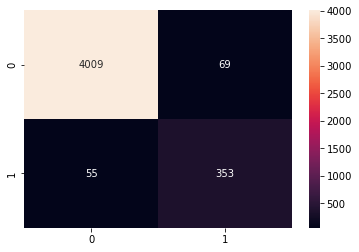

Training model with base loss function ce and lambda: 0.1
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.251786,0.211173,0.934240,0.707631,0.594010,0.875000,0.968206,0.688125,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.098996,0.171999,0.958092,0.801268,0.704461,0.928922,0.978924,0.787645,01:28
1,0.041126,0.129994,0.970352,0.839952,0.825059,0.855392,0.981117,0.823784,01:28
2,0.009406,0.135220,0.972358,0.853774,0.822727,0.887255,0.984359,0.839263,01:28


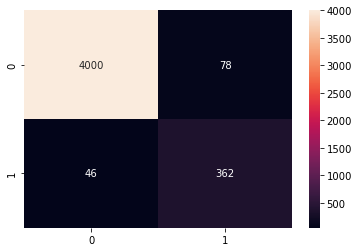

Training model with base loss function ce and lambda: 1
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.319560,0.253932,0.940259,0.724280,0.624113,0.862745,0.968502,0.703157,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.119226,0.246676,0.955417,0.790356,0.690476,0.924020,0.979953,0.776180,01:28
1,0.051399,0.169713,0.968792,0.830508,0.820574,0.840686,0.977612,0.813397,01:28
2,0.011433,0.163821,0.972136,0.848851,0.837709,0.860294,0.981127,0.833597,01:28


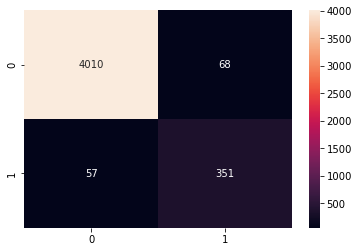

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7fe4c44b0560>
Trained epochs: epochs=3
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.711179,0.597568,0.950513,0.747153,0.697872,0.803922,0.964164,0.722090,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.294818,0.439490,0.967900,0.833718,0.788210,0.884804,0.976622,0.817689,01:27
1,0.122806,0.274572,0.969906,0.826255,0.869919,0.786765,0.976388,0.811052,01:27
2,0.034187,0.291948,0.971021,0.835859,0.861979,0.811275,0.980205,0.820435,01:27


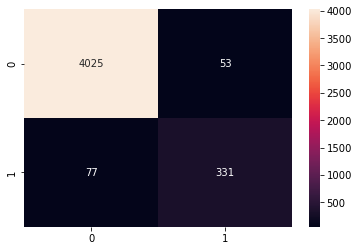

In [122]:
n_classes = 2
base_loss = 'ce'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

Training model with base loss function focal_loss and lambda: 0
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.051926,0.043659,0.897236,0.611626,0.465982,0.889706,0.946889,0.597904,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.018104,0.018760,0.958538,0.795604,0.721116,0.887255,0.981561,0.777952,01:25
1,0.010570,0.023790,0.963442,0.810624,0.766376,0.860294,0.970447,0.792084,01:25
2,0.005971,0.017391,0.968123,0.824108,0.827160,0.821078,0.978872,0.806588,01:27
3,0.002116,0.023751,0.971467,0.841975,0.848259,0.835784,0.981665,0.826321,01:26
4,0.000442,0.026949,0.972581,0.850547,0.843373,0.857843,0.981919,0.835491,01:26


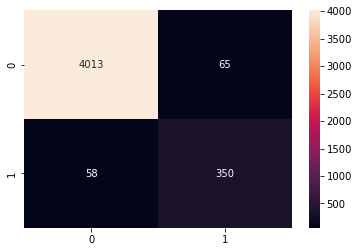

Training model with base loss function focal_loss and lambda: 0.1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.068379,0.046536,0.925546,0.679463,0.558360,0.867647,0.962426,0.659485,01:13


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.025245,0.035954,0.954525,0.784355,0.689591,0.909314,0.975604,0.768555,01:27
1,0.017739,0.030146,0.970575,0.846868,0.803965,0.894608,0.982035,0.832093,01:27
2,0.008289,0.032693,0.969015,0.836663,0.803612,0.872549,0.982500,0.820426,01:28
3,0.002576,0.039443,0.972804,0.854067,0.834112,0.875000,0.983602,0.839373,01:28
4,0.001002,0.040861,0.973027,0.855090,0.836066,0.875000,0.982612,0.840493,01:28


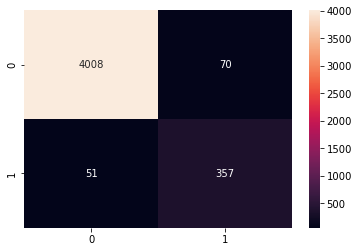

Training model with base loss function focal_loss and lambda: 1
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.115090,0.112421,0.944494,0.733119,0.651429,0.838235,0.967018,0.709647,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.048780,0.086238,0.958538,0.787671,0.737179,0.845588,0.973911,0.767027,01:28
1,0.040359,0.058120,0.966117,0.817746,0.800469,0.835784,0.981493,0.799304,01:28
2,0.022513,0.065449,0.968123,0.835821,0.786177,0.892157,0.982964,0.820253,01:28
3,0.004387,0.071922,0.969683,0.827411,0.857895,0.799020,0.982811,0.811432,01:28


In [ ]:
n_classes = 2
base_loss = 'focal_loss'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

In [ ]:
n_classes = 2
base_loss = 'ls'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

In [ ]:
n_classes = 2
base_loss = 'gls'
for l in lambdas:
    print(f'Training model with base loss function {base_loss} and lambda: {l}')
    train_model_with_loss(base_loss=base_loss, lambd=l)
    learners.append(learn)

## Test for different Cost Matrices

In [45]:
M = np.array([[0,1],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.259602,1.194937,0.926661,0.692236,0.559758,0.906863,0.968938,0.677776,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.486771,0.651485,0.964111,0.821310,0.750507,0.906863,0.979613,0.805994,01:27
1,0.376458,0.758381,0.958761,0.801289,0.713193,0.914216,0.972310,0.786149,01:27
2,0.204269,0.490568,0.970798,0.847851,0.805740,0.894608,0.978106,0.833142,01:28
3,0.091801,0.484341,0.971690,0.851809,0.812918,0.894608,0.981636,0.837370,01:26
4,0.046832,0.457778,0.972804,0.853012,0.838863,0.867647,0.979606,0.838178,01:26


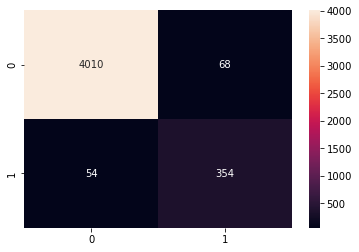

NameError: name 'logs' is not defined

In [51]:
n_classes = 2
base_loss = 'ce'
print(f'Training model with base loss function {base_loss} and lambda: 10')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=10)
logs.append(learn)

In [53]:
M = np.array([[0,10],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.705779,0.568676,0.954971,0.767281,0.723913,0.816176,0.963026,0.744091,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.250514,0.578741,0.956754,0.785398,0.715726,0.870098,0.970340,0.766098,01:28
1,0.245765,0.339994,0.971467,0.844660,0.836538,0.852941,0.982504,0.829000,01:27
2,0.135807,0.367004,0.968792,0.832134,0.814554,0.850490,0.975940,0.815171,01:27
3,0.055004,0.314210,0.971467,0.840796,0.853535,0.828431,0.978084,0.825240,01:28
4,0.008117,0.317318,0.970575,0.834171,0.855670,0.813725,0.981498,0.818348,01:28


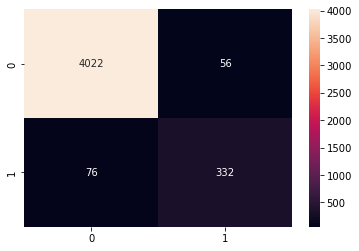

In [56]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
logs.append(learn)

In [58]:
M = np.array([[0,20],
            [1,0]], dtype=float)
M /= M.max()
M = torch.from_numpy(M)
M = M.to(torch.float32)

Training model with base loss function ce and lambda: 10
Architechture: <function resnet18 at 0x7f276ed998c0>
Trained epochs: epochs=5
Weight decay: wd=0.002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.666436,0.568632,0.951850,0.750000,0.710526,0.794118,0.966053,0.724821,01:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.273403,0.427738,0.967231,0.824791,0.802784,0.848039,0.976440,0.807101,01:28
1,0.221856,0.359380,0.970129,0.838942,0.823113,0.855392,0.976827,0.822672,01:28
2,0.123698,0.306251,0.971021,0.837500,0.854592,0.821078,0.977450,0.821797,01:28
3,0.033591,0.329164,0.968569,0.818533,0.861789,0.779412,0.977815,0.802587,01:28
4,0.007698,0.332226,0.970798,0.833967,0.863517,0.806373,0.978696,0.818555,01:28


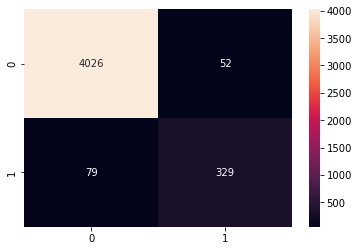

In [59]:
n_classes = 2
base_loss = 'ce'
l=10
print(f'Training model with base loss function {base_loss} and lambda: {l}')
learn, _ = train_model_with_loss(base_loss=base_loss, lambd=l)
logs.append(learn)

In [ ]:
for l in logs:
    l

In [66]:
valid_loss = logs[0].recorder.losses
valid_loss

AttributeError: 'Learner' object has no attribute 'after_epoch'